In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

from IPython.display import display
import toml


In [2]:
def extract_best(df):
    chosen_configurations = []
    for recall_cut in np.arange(0.9, 1.01, 0.01):
        chosen_configurations.append(df[df.Recall > recall_cut].sort_values("Query Time (microsecs)").head(1))
    df = pd.concat(chosen_configurations)
    return df


In [3]:
def extract_df(base_dir):
    full_df = []

    for file in os.listdir(base_dir):
        if file.endswith("json"):
            continue
        path = os.path.join(base_dir, file, "report.tsv")
        if not os.path.exists(path):
            print(f"{path} does not exists, skipping")
            continue
        try:
            df = pd.read_csv(path, sep="\t")
        except:
            print(f"Skipping {path}")
            continue
            
        #df['name'] = f"{(df['Memory Usage (Bytes)'].values[0] / 1024**3).round(2)} GByte"
        df['name'] = file
        config = toml.load(os.path.join(base_dir, file, "experiment_config.toml"))

        for k, v in config['indexing_parameters'].items():
            df[k] = v
        enriched_df = []
        for (i, row) in df.iterrows():
            params = config['query'][row.Subsection]
            for k,v in params.items():
                if k in row:
                    row[k+"1"] = v
                else:    
                    row[k] = v
            enriched_df.append(row)
            
        full_df.append(pd.DataFrame(enriched_df))
        
        
    if len(full_df) > 0:
        return pd.concat(full_df) 
    else:
        print("Nothing to concat!")
        return pd.DataFrame()
    


def grab_full_report(name):
    df = pd.read_csv(os.path.join(name, "report.tsv"), sep="\t")
    experiment_config_path = os.path.join(name, "experiment_config.toml")
    config = toml.load(experiment_config_path)
    enriched_df = []
    for (i, row) in df.iterrows():
        params = config['query'][row.Subsection]
        for k,v in params.items():
            if k in row:
                row[k+"1"] = v
            else:    
                row[k] = v
        enriched_df.append(row)
    return pd.DataFrame(enriched_df)

In [4]:
base_dir = ""
all_df = extract_df(base_dir)
#forward_index_size = 4313529200 # Cocondenser
forward_index_size = 6537222484 # E-splade

[2]



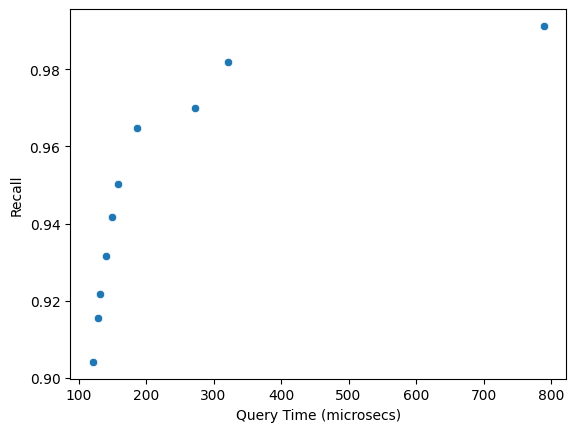

[2]



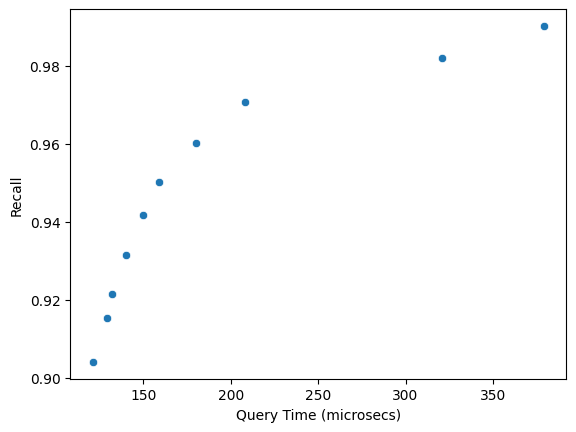

In [5]:

for mem_limit in [1.5, 2.0]:
    current_df = extract_best(all_df[all_df['Memory Usage (Bytes)'] <= mem_limit * forward_index_size])
    print(current_df['min-cluster-size'].unique())
    print()
    sns.scatterplot(data=current_df, x = "Query Time (microsecs)", y="Recall")
    plt.show()

In [26]:
def dump_best_config_from_gridsearch(df, model_name, forward_index_size, memory_budget_gb, 
                                    output_dir, base_dir, starting_recall=90):
    """
    Extract the best configuration from a grid search DataFrame and save TOML files for each recall level.
    
    Args:
        df: DataFrame containing grid search results

        model_name: Name of the model (e.g., "cocondenser_f16", "splade_v3", etc.)
        memory_budget_gb: Memory budget in GB for filtering results
        starting_recall: Starting recall level (default: 90)
        output_dir: Base directory for output files
    """
    
    memory_budget_bytes = memory_budget_gb * forward_index_size
    
    filtered_df = df[df['Memory Usage (Bytes)'] <= memory_budget_bytes]
    
    if len(filtered_df) == 0:
        print(f"No results found within memory budget of {memory_budget_gb}GB")
        return None
    
    best_df = extract_best(filtered_df)
    
    if len(best_df) == 0:
        print("No best configuration found in the filtered results!")
        return None
    
    print(f"Found {len(best_df)} best configurations")
    print("Best results summary:")
    display(best_df[['Recall', 'Query Time (microsecs)', 'RR@10', 'Memory Usage (Bytes)']].round(6))
    

    target_dir = os.path.join(output_dir, model_name, f"mem_budget_{memory_budget_gb}")
    os.makedirs(target_dir, exist_ok=True)
    



    base_experiment_path = list(filter(lambda x: not x.endswith(".json"), os.listdir(base_dir)))[0]

    reference_config_path = os.path.join(base_dir, base_experiment_path, "experiment_config.toml") # any of the base config file works
    if not os.path.exists(reference_config_path):
        print(f"Reference config not found at: {reference_config_path}")
    
        
    reference_config = toml.load(reference_config_path)
    

    created_files = []
    
    for i, (_, row) in enumerate(best_df.iterrows()):
        current_recall = starting_recall + i
        config_name = f"recall_{current_recall}.toml"
        target_config_path = os.path.join(target_dir, config_name)
        

        config = create_config_for_recall_level(reference_config, row, model_name, current_recall)
        

        with open(target_config_path, 'w') as f:
            toml.dump(config, f)
        

        with open(target_config_path, 'r') as f:
            content = f.read()
        

        content = content.replace(f'_comment = "Query configuration for recall {current_recall}%"\n', '')
        content = content.replace(f'_comment = "Query configuration for recall {current_recall}%"\r\n', '')
        
        with open(target_config_path, 'w') as f:
            f.write(content)
            
        created_files.append(target_config_path)
        print(f"Created: {config_name}")
    
    return created_files, best_df


def create_config_for_recall_level(reference_config, best_row, model_name, recall_level):
    """
    Create a TOML configuration for a specific recall level based on the best parameters.
    """
    
    config = {}
    
    config['name'] = f"{model_name}_recall_{recall_level}"
    config['title'] = f"Seismic {model_name.capitalize()} - Recall {recall_level}%"
    config['description'] = f"Optimized configuration for {model_name} targeting recall {recall_level}% from grid search"
    config['dataset'] = f"{model_name.capitalize()} on MS-MARCO"
    
    config['settings'] = reference_config['settings'].copy()
    config['folder'] = reference_config['folder'].copy() 
    for k, v in config['folder'].items():
        config['folder'][k] = ""
    config['filename'] = reference_config['filename'].copy()
    
    config['filename']['index'] = f"{model_name}_recall_{recall_level}"
    
    config['indexing_parameters'] = {
        'n-postings': int(best_row['n-postings']),
        'centroid-fraction': float(best_row['centroid-fraction']),
        'summary-energy': float(best_row['summary-energy']),
        'knn': int(best_row['knn1']),  # Note: using knn1 from the DataFrame
        'clustering-algorithm': str(best_row['clustering-algorithm']),
        'kmeans-doc-cut': int(best_row['kmeans-doc-cut']),
        'kmeans-pruning-factor': float(best_row.get('kmeans-pruning-factor', 0.005))  # Default if missing
    }
    
    additional_indexing_params = [
        'max-fraction', 'min-cluster-size', 'pruning-strategy', 'value-type'
    ]
    
    for param in additional_indexing_params:
        if param in best_row and pd.notna(best_row[param]):
            if param in ['max-fraction']:
                config['indexing_parameters'][param] = float(best_row[param])
            elif param in ['min-cluster-size']:
                config['indexing_parameters'][param] = int(best_row[param])
            else:
                config['indexing_parameters'][param] = str(best_row[param])
    
    config['query'] = {}
    
    config['query']['_comment'] = f"Query configuration for recall {recall_level}%"
    
    config['query'][f'recall_{recall_level}'] = {
        'query-cut': int(best_row['query-cut']),
        'heap-factor': float(best_row['heap-factor'])
    }
    
    if 'first_sorted' in best_row and pd.notna(best_row['first_sorted']):
        config['query'][f'recall_{recall_level}']['first_sorted'] = bool(best_row['first_sorted'])
    
    return config

In [28]:
model_name = "efficient-splade"


output_dir = "../experiments/best_configs/msmarco-v1/e-splade"

print(f"Looking for reference config at: {base_dir}/experiment_config.toml")

# Create TOML files for a given memory budget
created_files, best_results = dump_best_config_from_gridsearch(
    df=all_df,
    forward_index_size=forward_index_size,
    #base_experiment_path=base_dir, 
    model_name=model_name,
    memory_budget_gb=1.5,
    starting_recall=90, 
    output_dir=output_dir, 
    base_dir=base_dir
)

Looking for reference config at: ../grid_search_after_martino_imprv_2025-09-22_10:44:18.571348//experiment_config.toml
Found 10 best configurations
Best results summary:


,Recall,Query Time (microsecs),RR@10,Memory Usage (Bytes)
22,0.904083,121,0.379545,8284330020
15,0.915358,129,0.381196,8550180012
15,0.921605,132,0.379201,8712867498
23,0.931504,140,0.380836,8712867498
15,0.941648,150,0.382566,9051935744
23,0.950158,159,0.384033,9051935744
22,0.964742,186,0.386338,9511962077
20,0.970043,272,0.386430,8910020116
21,0.981848,321,0.386659,9511962077
18,0.991289,789,0.387335,9736540776


Created: recall_90.toml
Created: recall_91.toml
Created: recall_92.toml
Created: recall_93.toml
Created: recall_94.toml
Created: recall_95.toml
Created: recall_96.toml
Created: recall_97.toml
Created: recall_98.toml
Created: recall_99.toml
